In [1]:
import resiliencyTool as rt
import pandas as pd
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt

import seaborn as sns

warnings.simplefilter("ignore") # warning are ignored for now

Unable to determine R home: [WinError 2] The system cannot find the file specified


In [2]:
simulationName = 'strata_example'
network = rt.network.Network(simulationName)
simulation = rt.simulation.Sim(simulationName)

simulation.initialize_model_rp(network=network,
                               filename="return_period.csv",
                               iterationNumber=1,
                               maxTotalIteration=50)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


start= 1, stop= 41
start= 12, stop= 17

Strata  3
Sample size  14
Strata  4
Sample size  8
-----------------
 Kmeans solution 
-----------------
 *** Domain:  1  ***
 Number of strata:  4
 Sample size     :  8
Computations are being done on population data

Number of strata:  4
... of which with only one unit:  0
Input data have been checked and are compliant with requirements

 *** Domain :  1   1
 Number of strata :  10000
 *** Sample cost:  8
 *** Number of strata:  4
 *** Sample size :  8
 *** Number of strata :  4
---------------------------Strata = 0
number of samples = 2.0
Intensity samples between 0.7220000455295155 and 0.8067143337596561
Strata = 1
number of samples = 2.0
Intensity samples between 0.8067402652627897 and 0.9228968452373533
Strata = 2
number of samples = 2.0
Intensity samples between 0.9229545308002798 and 1.103576873849548
Strata = 3
number of samples = 2.0
Intensity samples between 1.103776959620264 and 1.5219990443393905


<AxesSubplot:xlabel='return_period', ylabel='intensity'>

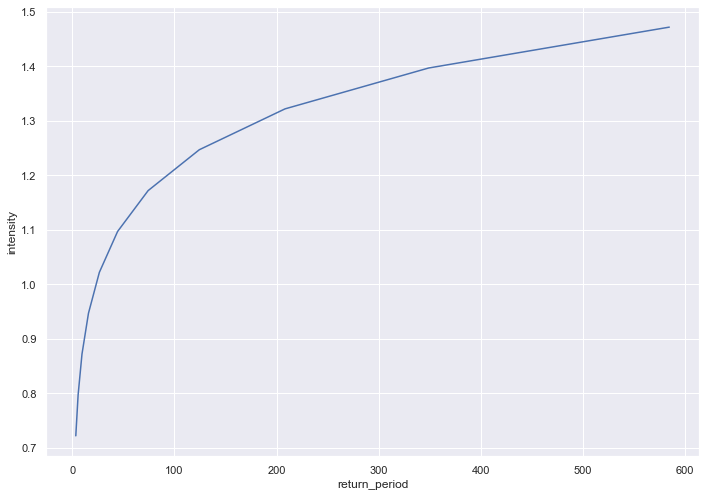

In [26]:
sns.lineplot(data=network.return_period.df_return_period, x='return_period', y='intensity')

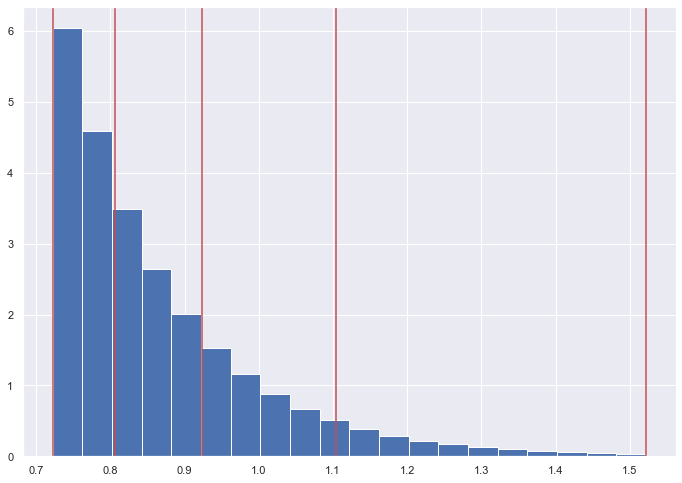

In [20]:
plt.hist(simulation.samples, density=True, bins=20)
for b in np.append(simulation.stratResults["Upper_X1"].values, simulation.stratResults["Lower_X1"].values[0]):
    plt.axvline(x = b, color = 'r')

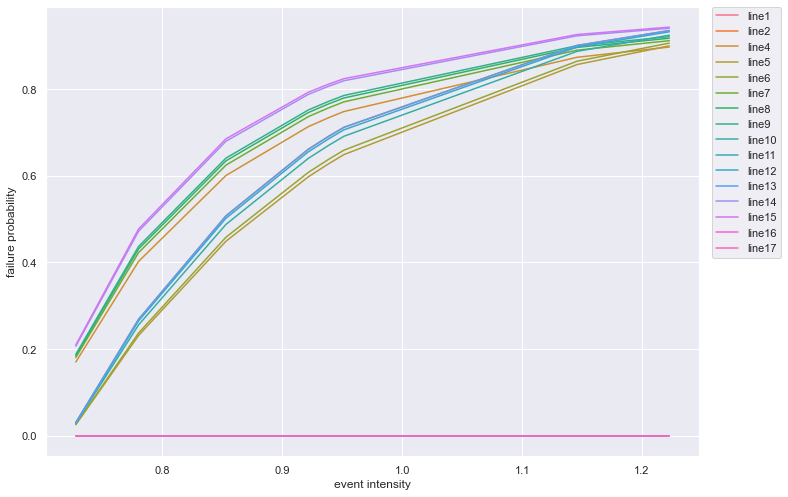

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = simulation.failureProbs[simulation.failureProbs['element type']=='Line']
sns.lineplot(data=df, x='event intensity', y='failure probability', hue='power element')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)